<a href="https://colab.research.google.com/github/ShanmugapriyanManoharan/OpenCV-Deep-Learning/blob/master/Denoising_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Convolutional Autoencoder Model

In [0]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from google.colab.patches import cv2_imshow

In [0]:
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		inputShape = (height, width, depth)
		chanDim = -1
		inputs = Input(shape=inputShape)
		x = inputs
		
		# Loop through the filter tuple
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
			
		# Flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)
		
		# Encoder Model
		encoder = Model(inputs, latent, name="encoder")
		
		# Latent-Space Representation
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		
		# Loop through the filter tuple
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
			
		# Apply a single CONV_TRANSPOSE layer used to recover the original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)
		
		# Decoder model
		decoder = Model(latentInputs, outputs, name="decoder")
		
		# Autoencoder = encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
		
		return (encoder, decoder, autoencoder)

Training Convolutional Autoencoder

In [0]:
EPOCHS = 25
BS = 32

In [4]:
# MNIST Dataset
((trainX, _), (testX, _)) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Adding channel dimension to every image in the dataset
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

# Pixel intensity to range [0,1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

In [0]:
# Sampling noise from a random normal distribution centered at 0.5 (as pixel instensity is [0,1])
trainNoise = np.random.normal(loc=0.5, scale=0.5, size=trainX.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=testX.shape)
trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

In [0]:
# Convolutional Autoencoder
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

In [8]:
# Train Autoencoder
A = autoencoder.fit(
	trainXNoisy, trainX,
	validation_data=(testXNoisy, testX),
	epochs=EPOCHS,
	batch_size=BS)

Epoch 1/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0281 - val_loss: 0.0193
Epoch 2/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0187 - val_loss: 0.0195
Epoch 3/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0177 - val_loss: 0.0180
Epoch 4/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0171 - val_loss: 0.0171
Epoch 5/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0168 - val_loss: 0.0185
Epoch 6/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0164 - val_loss: 0.0167
Epoch 7/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0162 - val_loss: 0.0161
Epoch 8/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0160 - val_loss: 0.0164
Epoch 9/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0158 - val_loss: 0.0163
Epoch 10/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.015

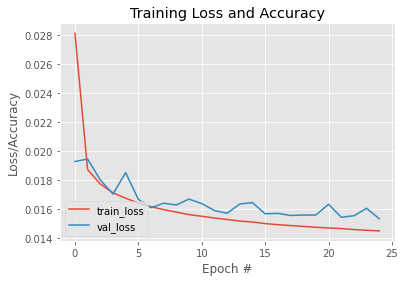

In [9]:
# Plotting Loss & Accuracy, saving the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, A.history["loss"], label="train_loss")
plt.plot(N, A.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

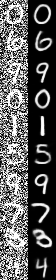

In [11]:
# Finally making the prediticion
decoded = autoencoder.predict(testXNoisy)
outputs = None

# Loop over the output samples
for i in range(10, 20): #samples can be increased by increase the upper limit of for loop
	# Get original and reconstructed images
	original = (testXNoisy[i] * 255).astype("uint16")
	reconstructed = (decoded[i] * 255).astype("uint16")
	
	# Stack the original and reconstructed images side-by-side
	output = np.hstack([original, reconstructed])
	
	if outputs is None:
		outputs = output
	
	# otherwise, stack vertically
	else:
		outputs = np.vstack([outputs, output])

cv2_imshow(outputs)